**watershed with vs without markers**

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from scipy import ndimage


def count_instances(labels):
    return len(np.unique(labels)) - 1
    
def load_sample(base_path, sample_id):
    sample_path = os.path.join(base_path, sample_id)
    img_file = os.listdir(os.path.join(sample_path, 'images'))[0]
    image = imread(os.path.join(sample_path, 'images', img_file))
    
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    elif image.shape[-1] == 4:
        image = image[:, :, :3]

    mask_dir = os.path.join(sample_path, 'masks')
    binary_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for mf in os.listdir(mask_dir):
        m = imread(os.path.join(mask_dir, mf), as_gray=True)
        binary_mask = np.maximum(binary_mask, (m > 0).astype(np.uint8))

    gt_count = len(os.listdir(mask_dir))
    return image, binary_mask, gt_count


def watershed_without_markers(binary_mask):
    distance = ndimage.distance_transform_edt(binary_mask)
    labels = watershed(-distance, mask=binary_mask)
    return labels


def watershed_with_markers(binary_mask, min_distance=7):
    distance = ndimage.distance_transform_edt(binary_mask)
    coords = peak_local_max(distance, min_distance=min_distance, labels=binary_mask)
    marker_mask = np.zeros(distance.shape, dtype=bool)
    marker_mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(marker_mask)
    labels = watershed(-distance, markers=markers, mask=binary_mask)
    return labels



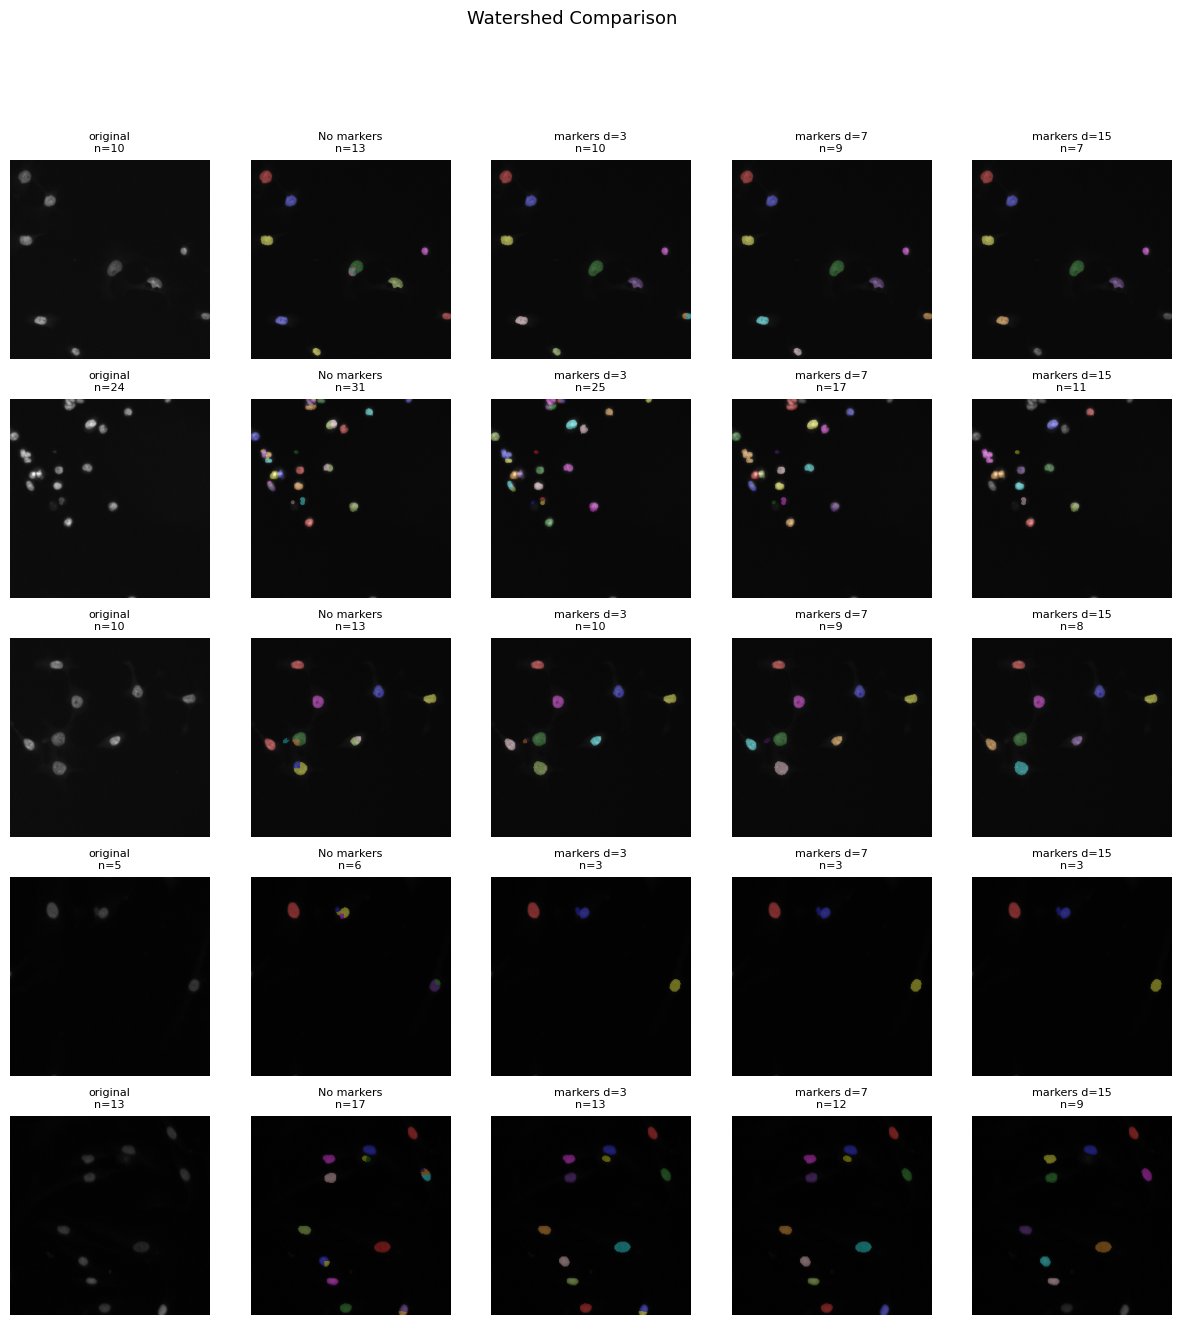

In [32]:

def compare_watershed(base_path, sample_ids, min_dist=[3, 7, 15]):
    
    n_rows = len(sample_ids)
    n_cols = 2 + len(min_dist)  # original + no marker + one per min distance

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    if n_rows == 1:
        axes = axes[np.newaxis, :]

    for row, sample_id in enumerate(sample_ids):
        image, binary_mask, gt_count = load_sample(base_path, sample_id)
        labels_no_marker = watershed_without_markers(binary_mask)

        # Original
        axes[row, 0].imshow(image)
        axes[row, 0].set_title(f'original\nn={gt_count}', fontsize=8)

        # Without markers
        axes[row, 1].imshow(label2rgb(labels_no_marker, image=image, bg_label=0))
        axes[row, 1].set_title(f'No markers\nn={count_instances(labels_no_marker)}', fontsize=8)

        # With markers 
        for col, md in enumerate(min_dist, start=2):
            labels_with_marker = watershed_with_markers(binary_mask, min_distance=md)
            axes[row, col].imshow(label2rgb(labels_with_marker, image=image, bg_label=0))
            axes[row, col].set_title(f'markers d={md}\nn={count_instances(labels_with_marker)}', fontsize=8)

        axes[row, 0].set_ylabel(f'Image {row+1}', fontsize=9)

    for ax in axes.flat:
        ax.axis('off')

    plt.suptitle('Watershed Comparison', fontsize=13)
    plt.show()



base_path = '/kaggle/input/datasets/mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask/data science bowl 2018/stage1_train 2'
sample_ids = os.listdir(base_path)[:5]  

compare_watershed(base_path, sample_ids, min_dist=[3, 7, 15])